In [165]:
from pinn import *
import torch

In [166]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [167]:
model = Model()

In [168]:
x = torch.Tensor([3., 1]).unsqueeze(0)
t = torch.Tensor([1., 1]).unsqueeze(0)
x.requires_grad = True
t.requires_grad = True
print(f"x: {x}, t: {t}")

x: tensor([[3., 1.]], requires_grad=True), t: tensor([[1., 1.]], requires_grad=True)


In [169]:
torch.concat((x, t), dim=0)

tensor([[3., 1.],
        [1., 1.]], grad_fn=<CatBackward0>)

In [163]:
u = model(torch.concat((x, t), dim=0))
print(u)

tensor([[0.4633],
        [0.1763]], grad_fn=<AddmmBackward0>)


In [164]:
torch.autograd.grad(u, x,torch.ones(2,1),  create_graph=True)[0]

tensor([[ 0.0957, -0.0436]], grad_fn=<SliceBackward0>)

In [154]:
u_x = torch.autograd.grad(u, x,torch.ones_like(x),  create_graph=True)[0]
u_t = torch.autograd.grad(u, t, torch.ones_like(t),create_graph=True)[0]
u_xx = torch.autograd.grad(u_x, x, torch.ones_like(x),create_graph=True)[0]
print(f"u_x: {u_x}, u_t: {u_t}, u_xx: {u_xx}")

RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([1, 2]) and output[0] has a shape of torch.Size([2, 1]).

In [93]:

u_x = torch.autograd.grad(u, x, create_graph=True)
u_x

(tensor([0.1769], grad_fn=<SliceBackward0>),)

let's code this equation

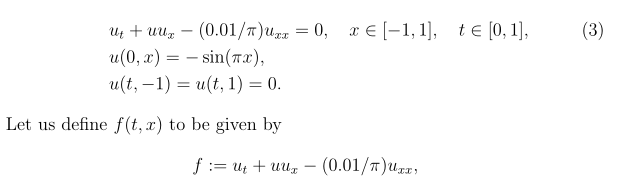

In [136]:
def u(t, x):
    return model(torch.concat((x, t)))

def f(t, x):
    u_x = torch.autograd.grad(u(t, x), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u(t, x), t, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True)[0]
    return u_t + u(t, x) * u_x - (0.01 / torch.pi) * u_xx

In [137]:
u(t, x)
f(t, x)

tensor([0.0640], grad_fn=<SubBackward0>)

In [139]:
N_u = 100 #number of points inside
N_f = 10000 #number of points intial and boundary
Batches = 10 #number of batches

#intial condtion
t_is = torch.zeros(N_u).to(device)
x_is = (2 * torch.rand(N_u) - 1).to(device)
u_is = -torch.sin(torch.pi * x_is).to(device)

#boundary condition
t_bs = torch.rand(N_u).to(device)
x_bs = torch.floor(torch.rand(10)*2).to(device)
x_bs = x_bs * 2 - 1  # Convert 0 to -1, 1 stays 1
u_bs = torch.zeros(N_u).to(device)

#collocation points
t_fs = torch.rand(N_f).to(device)
x_fs = (2 * torch.rand(N_f) - 1).to(device) 

#training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mse_loss = torch.nn.MSELoss()
for batch in range(Batches):

    us = u(t_is, x_is)
    ub = u(t_bs, x_bs)
    
    mse_u = (mse_loss(us, u_is) + mse_loss(ub, u_bs)).mean()
    f_pred = f(t_fs, x_fs)
    mse_f = mse_loss(f_pred, torch.zeros(f_pred.shape).to(device)).mean()

    loss = mse_u + mse_f
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Batch {batch+1}/{Batches}, Loss: {loss.item()}, MSE_u: {mse_u.item()}, MSE_f: {mse_f.item()}")
    if loss.item() < 1e-5:
        break



RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x200 and 2x32)

In [130]:
labels = torch.floor(torch.rand(10)*2)
print(labels)
labels = labels * 2 - 1  # Convert 0 to -1, 1 stays 1
print(labels)

tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([ 1.,  1., -1., -1., -1.,  1., -1., -1., -1., -1.])
